# HRDPS EOFs

This notebook demonstrates a quick example of loading HRDPS surface wind timeseries from erddap and performing a simple EOF analysis on the $U$ and $V$ vector fields. For more detail see [CPCA_varimax](https://nbviewer.jupyter.org/github/SalishSeaCast/analysis-ben/blob/master/notebooks/CPCA_varimax.ipynb).

***

In [180]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs, feature
from scipy import signal
from datetime import datetime, timedelta
from calendar import monthrange
from tqdm.notebook import tqdm

%matplotlib inline

In [193]:
plt.rcParams['font.size'] = 14

***

## Get Data

Define erddap links as `xarray` netCDF objects

In [2]:
# Define erddap netCDF objects
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')

Load data from erddap into `numpy` using `xarray`

In [3]:
# Load data from erddap in month intervals
y = 2019
variables, subsample = {'u_wind': [], 'v_wind': []}, slice(None, None, 3)
for m in tqdm(range(1, 13), desc=f'Loading {y} data'):
    trange = [datetime(y, m, d, h) for d, h in zip([1, monthrange(y, m)[1]], [0, 23])]
    for key in ['u_wind', 'v_wind']:
         variables[key].append(HRDPS[key].sel(time=slice(*trange)).isel(gridY=subsample, gridX=subsample).values)

# Final concatenation
for key in ['u_wind', 'v_wind']:
    variables[key] = np.vstack(variables[key])

# Construct time array
trange = [datetime(y, 1, 1), datetime(y, 12, 31, 23)]
variables['time'] = HRDPS.time.sel(time=slice(*trange)).values.astype('datetime64[s]').astype(datetime)

***

## Methodology

(from Preisendorfer and Mobley 1988, *Principal Component Analysis in Meteorology and Oceanography*)

Let $\mathbf{Z}$ be a complex $n \times p$ matrix ($p \le n$)

$$\mathbf{Z} = \mathbf{X} + i\mathbf{Y}$$

where $\mathbf{X}$ and $\mathbf{Y}$ are real-valued $n \times p$ matrices containing $n$ respective $u$ and $v$ velocity anomalies at $p$ locations.

In [6]:
# Build Z as vector of X and Y
Z = []
for key in ['u_wind', 'v_wind']:
    Z.append((variables[key] - variables[key].mean(axis=0, keepdims=True)).reshape(len(variables['time']), -1))

# Convert Z to complex matrix
Z = Z[0] + 1j * Z[1]

The PC and EOF matrices are easily obtained using Singular Value Decomposition.

$$\mathbf{Z} = \mathbf{A}'\mathbf{L}^{1/2}\mathbf{E}^\mathrm{T}$$

In [8]:
# Singular value decomposition of Z
A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)

$\mathbf{E}$ is the EOF matrix. The PC loading matrix $\mathbf{A}$ is simply the product of $\mathbf{A}'$ and $\mathbf{L}^{1/2}$.

In [11]:
# A from SVD and synthesis formula
A = A_prime.dot(np.diag(sqrtL))

The variances are given by the diagonals of $\mathbf{L}$. We can normalize to obtain the variance fractions.

In [78]:
# Extract explained variance
FracVar = sqrtL**2/(sqrtL**2).sum()

***

## Visualization

### Variance fractions by mode

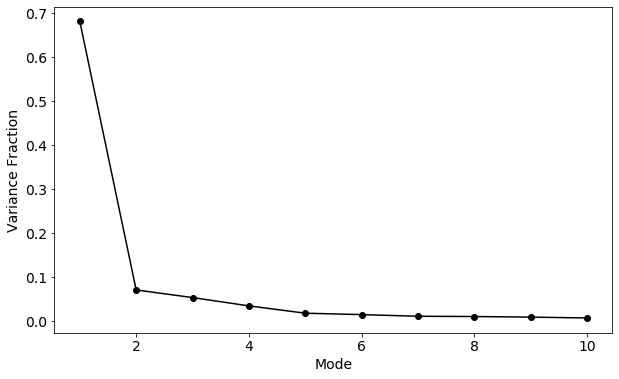

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 11), FracVar[:10], 'ko-')
ax.set_xlabel('Mode')
ax.set_ylabel('Variance Fraction')
plt.show()

***

### PC timeseries

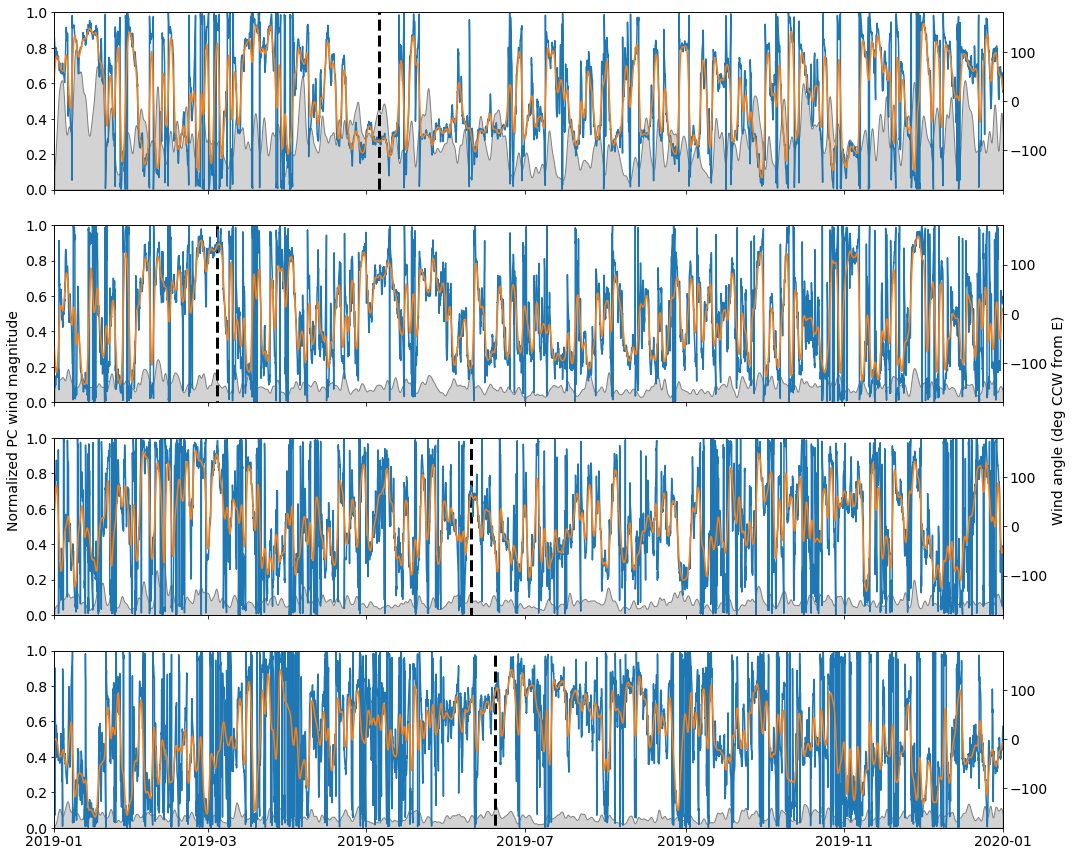

In [170]:
# Filter window
window = signal.get_window('blackman', 72)

# Normalization factor for PC magnitude
norm_fac = 1 / np.absolute(A).max()

# Loop through panels and modes
fig, axs = plt.subplots(4, 1, figsize=(17, 15))
for ax, mode, t in zip(axs, range(4), [3000, 1500, 3850, 4070]):
    
    # Calculate raw and filtered wind magnitude and angle
    mag, angle = norm_fac * np.absolute(A[:, mode]), np.angle(A[:, mode], deg=True)
    mag_smooth, angle_smooth = [signal.convolve(var, window / sum(window), mode='same') for var in [mag, angle]]
    
    # Plot magnitude
    ax.fill_between(variables['time'], mag_smooth, facecolor='lightgray', edgecolor='gray')
    ax.set_xlim([datetime(2019, 1, 1), datetime(2020, 1, 1)])
    ax.set_ylim([0, 1])
    
    # Plot angle
    ax2 = ax.twinx()
    ax2.plot(variables['time'], angle)
    ax2.plot(variables['time'], angle_smooth)
    ax2.set_ylim([-180, 180])
    if mode == 2:
        ax.set_ylabel('Normalized PC wind magnitude', y=1.1)
        ax2.set_ylabel('Wind angle (deg CCW from E)', y=1.1)
    
    # Indicate stable period to obtain spatial field
    ax.plot([variables['time'][t], variables['time'][t]], ylim, 'k--', linewidth=3)
    if mode < 3: ax.xaxis.set_ticklabels('')

***

### Spatial patterns (EOFs)

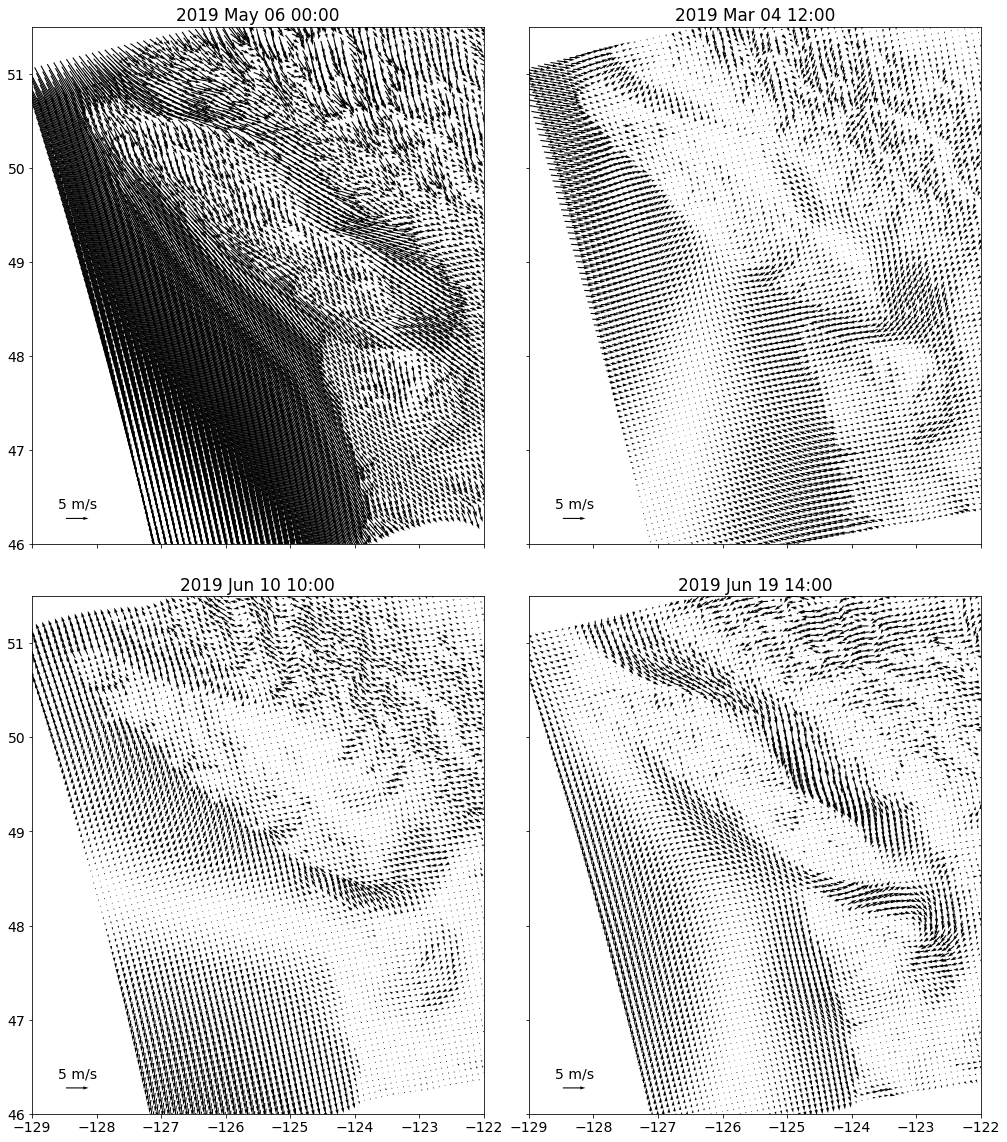

In [194]:
# Define lon and lat arrays
lon = grid.longitude.isel(gridY=subsample, gridX=subsample).values - 360
lat = grid.latitude.isel(gridY=subsample, gridX=subsample).values

# Loop through panels, modes
fig, axs = plt.subplots(2, 2, figsize=(17, 20), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axs = axs.flatten()
for ax, mode, t in zip(axs, range(4), [3000, 1500, 3850, 4070]):
    
    # Formatting
    ax.set_xlim([-129, -122])
    ax.set_ylim([46, 51.5])
    ax.set_title(variables['time'][t].strftime('%Y %b %d %H:%M'))
    if mode in [0, 1]: ax.xaxis.set_ticklabels('')
    if mode in [1, 3]: ax.yaxis.set_ticklabels('')
    
    # Construct spatial mode at times shown in PC timeseries
    E = A[:, mode, np.newaxis].dot(E_T[mode, np.newaxis, :])[t, :].reshape(lon.shape)
    
    # Plot vector fields
    q = ax.quiver(lon, lat, E.real, E.imag, scale=100)
    ax.quiverkey(q, 0.1, 0.05, 5, '5 m/s', transform=ax.transAxes)